In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt  # for plotting images, spectra, and metrics
from scipy.fft import fft2, fftshift  # for frequency-domain transforms

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

import shutil  # only if you need to move/copy datasets


2025-09-22 14:04:37.565934: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-22 14:04:37.578121: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-09-22 14:04:37.589858: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-09-22 14:04:37.593361: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-09-22 14:04:37.602991: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Base path to your dataset
BASE_PATH = '/cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake'

train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'valid')
test_dir = os.path.join(BASE_PATH, 'test')

# Check paths
print(f"Training directory: {train_dir}")
print(f"Validation directory: {val_dir}")
print(f"Test directory: {test_dir}")

Training directory: /cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake/train
Validation directory: /cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake/valid
Test directory: /cluster/home/ctknight22/CS488/realvsfake/realvsfake/real_vs_fake/real-vs-fake/test


In [3]:
# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=32,
    image_size=(128, 128)  # matches your FFT preprocessing
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    shuffle=True,
    batch_size=32,
    image_size=(128, 128)
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    shuffle=False,  # usually don't shuffle test data
    batch_size=32,
    image_size=(128, 128)
)

Found 100001 files belonging to 2 classes.


2025-09-22 14:04:53.637385: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22126 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:82:00.0, compute capability: 8.6


Found 20000 files belonging to 2 classes.
Found 20001 files belonging to 2 classes.


In [4]:
def standardize_image(image, label):
    """
    Converts an image to grayscale and normalizes its pixel values to [0, 1].
    """
    # Convert image to grayscale
    image = tf.image.rgb_to_grayscale(image)
    
    # Normalize pixel values to the [0, 1] range
    image = image / 255.0 
    
    return image, label

In [5]:
# Use AUTOTUNE to allow TensorFlow to find the best parallel settings
AUTOTUNE = tf.data.AUTOTUNE

# Apply the standardization function to each dataset
train_std = train_dataset.map(standardize_image, num_parallel_calls=AUTOTUNE)
val_std = val_dataset.map(standardize_image, num_parallel_calls=AUTOTUNE)
test_std = test_dataset.map(standardize_image, num_parallel_calls=AUTOTUNE)

# Configure datasets for optimal performance
train_std = train_std.cache().prefetch(buffer_size=AUTOTUNE)
val_std = val_std.cache().prefetch(buffer_size=AUTOTUNE)
test_std = test_std.cache().prefetch(buffer_size=AUTOTUNE)

print("Standardization applied successfully.")

Standardization applied successfully.


\n--- Verifying a batch of standardized images ---
Shape of image batch: (32, 128, 128, 1)
Minimum pixel value: 0.0
Maximum pixel value: 0.99990004


2025-09-22 14:05:05.249301: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


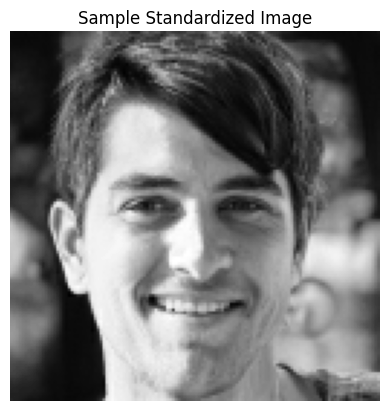

2025-09-22 14:05:05.393349: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
for images, labels in train_std.take(1):
    print("\\n--- Verifying a batch of standardized images ---")
    
    # Check the shape: The last dimension should now be 1 (for grayscale)
    print("Shape of image batch:", images.shape) 
    
    # Check the data range: Values should be between 0 and 1
    print("Minimum pixel value:", tf.reduce_min(images).numpy())
    print("Maximum pixel value:", tf.reduce_max(images).numpy())
    
    # Display the first image in the batch
    plt.imshow(images[0], cmap='gray')
    plt.title("Sample Standardized Image")
    plt.axis('off')
    plt.show()

In [7]:
# Create smaller subsets for faster development
SUBSET_BATCHES = 20 # 20 batches * 32 images/batch = 640 images
train_subset = train_dataset.take(SUBSET_BATCHES)
val_subset = val_dataset.take(SUBSET_BATCHES)

print(f"Created a training subset with {SUBSET_BATCHES} batches.")

Created a training subset with 20 batches.


In [8]:
def transform_to_fft(images):
    """
    Takes a batch of standardized images and returns their 2D log-magnitude spectra.
    """
    fft_images = []
    for img in images.numpy(): # Convert tensor to numpy to use scipy
        # Remove the channel dimension for 2D FFT
        img_squeezed = np.squeeze(img, axis=-1)

        # Apply 2D FFT and shift the zero-frequency component to the center
        fft = fft2(img_squeezed)
        fft_shifted = fftshift(fft)

        # Calculate the log-magnitude spectrum
        magnitude_spectrum = np.log(np.abs(fft_shifted) + 1)

        # Add the channel dimension back for consistency
        fft_images.append(np.expand_dims(magnitude_spectrum, axis=-1))

    return np.array(fft_images, dtype=np.float32)

def fft_wrapper(image, label):
    """A TensorFlow wrapper for the FFT function."""
    fft_image = tf.py_function(
        func=transform_to_fft,
        inp=[image],
        Tout=tf.float32
    )
    fft_image.set_shape([None, 128, 128, 1])
    return fft_image, label

Shape of FFT image batch: (32, 128, 128, 1)


2025-09-22 14:05:20.278115: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


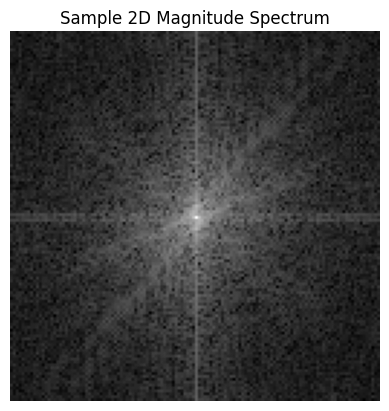

2025-09-22 14:05:20.324808: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [9]:
# Apply the FFT transformation to your standardized subset
train_fft = train_std.map(fft_wrapper, num_parallel_calls=AUTOTUNE)

# --- Verify the Output ---
for images_fft, labels in train_fft.take(1):
    print("Shape of FFT image batch:", images_fft.shape)

    # Display the first FFT spectrum in the batch
    plt.imshow(images_fft[0], cmap='gray')
    plt.title("Sample 2D Magnitude Spectrum")
    plt.axis('off')
    plt.show()

In [10]:
def azimuthal_average(spectrum):
    """Calculates the azimuthally averaged 1D profile of a 2D spectrum."""
    center_y, center_x = np.array(spectrum.shape) // 2
    y, x = np.indices(spectrum.shape)
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2).astype(int)
    tbin = np.bincount(r.ravel(), weights=spectrum.ravel())
    nr = np.bincount(r.ravel())
    radial_profile = np.divide(tbin, nr, out=np.zeros_like(tbin, dtype=float), where=nr!=0)
    return radial_profile

def process_to_1d_profile(images_fft):
    """Takes a batch of 2D spectra and returns their 1D profiles."""
    profiles = []
    for spectrum in images_fft.numpy():
        profile = azimuthal_average(np.squeeze(spectrum, axis=-1))

        # Pad or truncate the profile to a fixed length for the model.
        fixed_length = 91
        if len(profile) < fixed_length:
            profile = np.pad(profile, (0, fixed_length - len(profile)))
        else:
            profile = profile[:fixed_length]
        profiles.append(profile)
    return np.array(profiles, dtype=np.float32)

def profile_wrapper(image_fft, label):
    """TensorFlow wrapper for the 1D profile function."""
    profile = tf.py_function(
        func=process_to_1d_profile,
        inp=[image_fft],
        Tout=tf.float32
    )
    profile.set_shape([None, 91])
    return profile, label

Shape of final feature batch: (32, 91)


2025-09-22 14:05:26.547567: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


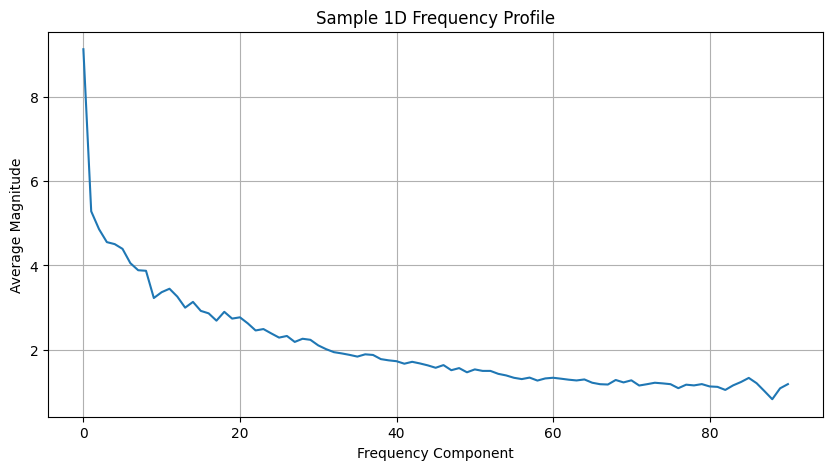

In [11]:
# Apply the final transformation to get 1D profiles
train_processed = train_fft.map(profile_wrapper, num_parallel_calls=AUTOTUNE)

# --- Verify the Final Output ---
for features, labels in train_processed.take(1):
    print("Shape of final feature batch:", features.shape)

    # Plot the first feature vector in the batch
    plt.figure(figsize=(10, 5))
    plt.plot(features[0])
    plt.title("Sample 1D Frequency Profile")
    plt.xlabel("Frequency Component")
    plt.ylabel("Average Magnitude")
    plt.grid(True)
    plt.show()

In [12]:
# 1. Define the MLP model architecture
model = Sequential([
    # Input layer: The shape must match your 1D frequency profile length (91)
    Dense(128, activation='relu', input_shape=(91,)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output layer: A single neuron with a sigmoid activation for binary classification
    Dense(1, activation='sigmoid') 
])

# 2. Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)

# Print a summary of the model to check it
model.summary()

# 3. Train the model on your processed subset data
# Note: Since you're using a small subset, training will be very fast.
# We'll use the validation data we created earlier as well.
val_processed = val_std.map(fft_wrapper, num_parallel_calls=AUTOTUNE)
val_processed = val_processed.map(profile_wrapper, num_parallel_calls=AUTOTUNE)

history = model.fit(
    train_processed,
    validation_data=val_processed,
    epochs=5 # We can train for a few epochs to see it work
)

/mounts/faraday/software/anaconda/envs/py312/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        11,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,097 (78.50 KB)

 Trainable params: 20,097 (78.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


I0000 00:00:1758564333.731116 3409373 service.cc:146] XLA service 0x7f9b540095b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758564333.731147 3409373 service.cc:154]   StreamExecutor device (0): NVIDIA RTX A5000, Compute Capability 8.6
2025-09-22 14:05:33.781108: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-22 14:05:34.122351: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902


  31/3126 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.5292 - loss: 0.9742 

I0000 00:00:1758564335.404218 3409373 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3126/3126 ━━━━━━━━━━━━━━━━━━━━ 78s 24ms/step - accuracy: 0.5106 - loss: 0.7030 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/5
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 74s 23ms/step - accuracy: 0.4982 - loss: 0.6932 - val_accuracy: 0.5795 - val_loss: 0.6903
Epoch 3/5
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 75s 24ms/step - accuracy: 0.5394 - loss: 0.6888 - val_accuracy: 0.5835 - val_loss: 0.6784
Epoch 4/5
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 75s 24ms/step - accuracy: 0.5687 - loss: 0.6818 - val_accuracy: 0.5850 - val_loss: 0.6765
Epoch 5/5
3126/3126 ━━━━━━━━━━━━━━━━━━━━ 75s 24ms/step - accuracy: 0.5746 - loss: 0.6801 - val_accuracy: 0.5839 - val_loss: 0.6745


In [13]:
# Print the final training and validation accuracy
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")

# Print all accuracy values to see the training progression
print("\nTraining accuracy per epoch:")
for epoch, acc in enumerate(history.history['accuracy'], 1):
    print(f"Epoch {epoch}: {acc:.4f}")
    
print("\nValidation accuracy per epoch:")
for epoch, acc in enumerate(history.history['val_accuracy'], 1):
    print(f"Epoch {epoch}: {acc:.4f}")

Final Training Accuracy: 0.5768
Final Validation Accuracy: 0.5839

Training accuracy per epoch:
Epoch 1: 0.5055
Epoch 2: 0.5021
Epoch 3: 0.5477
Epoch 4: 0.5727
Epoch 5: 0.5768

Validation accuracy per epoch:
Epoch 1: 0.5000
Epoch 2: 0.5795
Epoch 3: 0.5835
Epoch 4: 0.5850
Epoch 5: 0.5839
